# Random Forest Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, calculate_metrics, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

In [4]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [5]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [6]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


(288, 27)

In [7]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [8]:
os.chdir(os.path.expanduser('../data'))

In [9]:
df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

## Cross validation to calculate optimal number of months

In [13]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'Random Forest Model for {no_months} months')
    x = []
    for date in days_to_recalculate:
        indicators = data_provider.calculate_principal_component_from_indicators(
            date, periods=no_months, indicators=all_indicators)
        x.append(indicators.values)

    x_pca = np.array(x)
    x_train = x_pca[:val_split]
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_val = x_pca[val_split:test_split]
    x_val = x_val.reshape(x_val.shape[0], -1)
    x_test = x_pca[test_split:]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = RandomForestRegressor(n_estimators=50, random_state=42)
        model.fit(x_train_fold, y_train_fold)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation,
            df_returns_val, df_countries.columns)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

Random Forest Model for 3 months
Sharpe fold 0.40361996149791335
Sharpe fold 0.4020902516643324
Sharpe fold 0.40887535199154357
Sharpe fold 0.38470504754163737
Sharpe fold 0.39963288816512454
Mean Sharpe 0.39978470017211026
Random Forest Model for 4 months
Sharpe fold 0.3929695094852186
Sharpe fold 0.3971954678327421
Sharpe fold 0.4071036957732952
Sharpe fold 0.3973368934378147
Sharpe fold 0.3947115945498096
Mean Sharpe 0.397863432215776
Random Forest Model for 5 months
Sharpe fold 0.41165995432956826
Sharpe fold 0.4130186478674075
Sharpe fold 0.4054892306349675
Sharpe fold 0.3992075827174863
Sharpe fold 0.4072187605999184
Mean Sharpe 0.4073188352298696
Random Forest Model for 6 months
Sharpe fold 0.4093326028120294
Sharpe fold 0.4220871715246267
Sharpe fold 0.4099877961199063
Sharpe fold 0.4059220072597706
Sharpe fold 0.4131555969734905
Mean Sharpe 0.4120970349379647
Random Forest Model for 7 months
Sharpe fold 0.4187857822965934
Sharpe fold 0.41448249139545035
Sharpe fold 0.417880177

In [17]:
# best_month_no = 6

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=best_month_no, indicators=all_indicators)
    x.append(indicators.values)

x_pca = np.array(x)
x_train = x_pca[:val_split]
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_pca[test_split:]
x_test = x_test.reshape(x_test.shape[0], -1)

## Hiperparameters Tuning

In [20]:
params = {
    "n_estimators": [10, 25, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [5, 10, 20, 50],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [2, 4, 6],
    "bootstrap": [True, False],
}

model_rf = RandomForestRegressor(random_state=42)

rf_randomsearch = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=params,
    n_iter=500,
    cv=3,
    verbose=2,
    random_state=42,
)

rf_randomsearch.fit(x_train, y_train)

best_parameters = rf_randomsearch.best_params_

print("Best Parameters:", best_parameters)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=25; tota

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
474 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
474 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_pa

Best Parameters: {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


## Best Model training

In [45]:
best_model = RandomForestRegressor(random_state=42, **best_parameters)
best_model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                      min_samples_leaf=2, min_samples_split=4, n_estimators=150,
                      random_state=42)

## Backtesting

In [46]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [47]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [48]:
total_returns_model_dnn, cum_total_returns_model_dnn = calculate_returns_for_model(
    best_model, x_test, dates_for_test, df_returns_test, selected_countries)

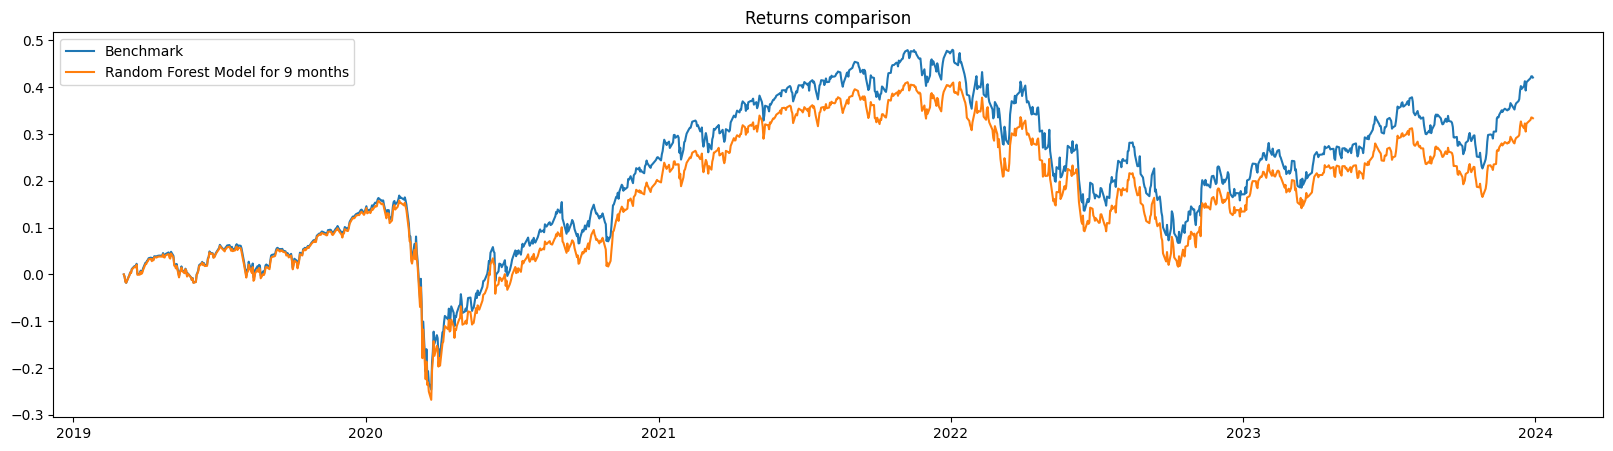

In [49]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_model_dnn,
         label=f'Random Forest Model for {best_month_no} months')

plt.legend()
plt.title('Returns comparison')
plt.show()

In [50]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_model_dnn, df_results,
                  f'Random Forest Model for {best_month_no} months', benchmark_returns)
df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Random Forest Model for 9 months,0.061601,0.202288,0.304522,0.353382,-0.367688,493.0,0.167536,-0.584933
